## DEAD

Fitting a model (or two) based on our proposal.

- **Goal:** Build a model to predict sales in a month for any given store.
- **Response Variable:** Monthly Sales
- **Possible Features:** store, month, county, population stuff, proximity stuff, alcohol categories

In [96]:
import duckdb as db 
con = db.connect()
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
# MAIN TABLE
con.execute("""
        DROP TABLE IF EXISTS sales;
        CREATE TABLE sales AS 
        SELECT EXTRACT(MONTH FROM date) AS month, EXTRACT (YEAR FROM date) AS year,
            store, city, county, 
            category_name AS category, sale_bottles AS bottles, sale_dollars AS dollars
        FROM read_parquet('../data/iowa_liquor_2023_2025.parquet');
""")
sales = con.execute("SELECT * FROM sales").df()

# POPULATION
con.execute(
"""
        DROP TABLE IF EXISTS population;
        CREATE TABLE population AS
        SELECT name AS county, year_1 AS year, popestimate AS population, over21, propOver21, median_age_tot AS median_age, (POPEST_MALE / (POPEST_FEM + POPEST_MALE)) AS pct_male
        FROM read_csv_auto('../data/pop.csv');
"""
)
pop = con.execute("SELECT * FROM population").df()

# PROXIMITY
con.execute(
"""
        DROP TABLE IF EXISTS proximity;
        CREATE TABLE proximity AS
        SELECT county
        FROM read_csv_auto('../data/proximity.csv');
"""
)
prox = con.execute("SELECT * FROM proximity").df()




In [98]:
#Reading in socioeconomic data
socioeconomic = pd.read_csv("../data/HDPulse_socioeconomic_data.csv")

socioeconomic["County"] = socioeconomic["County"].str.replace(r"\s+County$", "", regex=True)
socioeconomic.rename(columns={
    "County": "county",
    "FIPS": "fips",
    "% People (Education: Less Than 9th Grade)": "pct_less_than_9th_grade",
    "People (Education: Less Than 9th Grade)": "less_than_9th_grade",
    "% People (Unemployed)": "pct_unemployed",
    "People (Unemployed)": "unemployed",
    "% People (Below Poverty)": "pct_below_poverty",
    "People (Below Poverty)": "below_poverty",
    "% People (<150% Of Poverty)": "pct_below_150pct_poverty",
    "People (<150% Of Poverty)": "below_150pct_poverty",
    "% Families (Below Poverty)": "pct_families_below_poverty",
    "Families (Below Poverty)": "families_below_poverty",
    "% People (White)": "pct_white",
    "People (White)": "white",
    "% People (Hispanic)": "pct_hispanic",
    "People (Hispanic)": "hispanic",
    "% People (Foreign Born)": "pct_foreign_born",
    "People (Foreign Born)": "foreign_born",
    "% People (Black)": "pct_black",
    "People (Black)": "black",
    "% People (API)": "pct_api",
    "People (API)": "api",
    "% People (AI/AN)": "pct_aian",
    "People (AI/AN)": "aian",
    "% Households (language Isolation)": "pct_language_isolation",
    "Households (language Isolation)": "language_isolation",
    "% People(Education: Less Than High School)": "pct_less_than_high_school",
    "People(Education: Less Than High School)": "less_than_high_school",
    "% People (Education: At Least Bachelor's Degree)": "pct_at_bachelor_degree"
}, inplace=True)
socioeconomic.head()

,county,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree
0,Adair,19001.0,2.1,110.0,4.2,162.0,10.3,753.0,21.8,1591.0,5.0,92.0,94.9,7091.0,2.9,214.0,1.6,120.0,1.4,101.0,0.5,34.0,0.4,27.0,0.0,0.0,5.5,287.0,20.0
1,Adams,19003.0,2.6,68.0,2.9,53.0,9.5,339.0,17.7,629.0,3.6,35.0,95.4,3475.0,0.7,27.0,0.2,9.0,0.4,13.0,0.0,0.0,0.5,20.0,0.3,5.0,7.4,197.0,24.5
2,Allamakee,19005.0,3.0,293.0,3.6,252.0,12.1,1657.0,19.8,2716.0,9.4,350.0,90.4,12690.0,8.7,1225.0,6.7,937.0,1.8,246.0,0.5,76.0,0.8,115.0,4.4,265.0,7.5,721.0,19.9
3,Appanoose,19007.0,5.5,480.0,6.9,375.0,20.4,2468.0,31.9,3851.0,10.8,346.0,95.1,11641.0,1.7,212.0,1.2,150.0,1.0,121.0,0.4,53.0,0.1,7.0,1.0,51.0,10.3,907.0,19.3
4,Audubon,19009.0,2.7,108.0,1.9,52.0,11.8,649.0,20.9,1147.0,7.1,109.0,95.2,5351.0,2.0,115.0,0.9,48.0,0.3,15.0,0.1,7.0,0.2,12.0,0.9,23.0,8.0,322.0,20.6


In [99]:
#aggregating the 2 education statistics
socioeconomic["pct_high_school_lower"] = socioeconomic["pct_less_than_high_school"] + socioeconomic["pct_less_than_9th_grade"]

In [100]:
prox = pd.DataFrame(prox.value_counts())
prox.rename(columns={'count': 'store_count'}, inplace=True)
prox.reset_index(inplace=True)
prox.head()

,county,store_count
0,POLK,317
1,LINN,168
2,SCOTT,112
3,BLACK HAWK,108
4,JOHNSON,93


## Creating the Dataset

First, I am going to engineer the category column a little bit to use as features. Knowing which alcohol sells the best is could be useful for telling Booze R Us what they should buy in order to increase profits.

In [102]:
con.execute("""
    CREATE OR REPLACE TABLE sales AS
    SELECT *,
        CASE
            WHEN category ILIKE '%VODKA%' THEN 'Vodka'
            WHEN category ILIKE '%WHISK%' THEN 'Whiskey'
            WHEN category ILIKE '%TEQUILA%' OR category ILIKE '%MEZCAL%' THEN 'Tequila'
            WHEN category ILIKE '%RUM%' THEN 'Rum'
            ELSE 'Other'
        END AS super_category
    FROM sales
""")
sales = con.execute("SELECT * FROM sales").df()

In [103]:
sales.head()

,month,year,store,city,county,category,bottles,dollars,super_category
0,1,2023,4829,DES MOINES,POLK,100% AGAVE TEQUILA,12,261.00,Tequila
1,1,2023,4829,DES MOINES,POLK,AMERICAN VODKAS,60,418.80,Vodka
2,1,2023,4829,DES MOINES,POLK,IMPORTED FLAVORED VODKA,24,358.56,Vodka
3,1,2023,4829,DES MOINES,POLK,CREAM LIQUEURS,12,306.00,Other
4,1,2023,4829,DES MOINES,POLK,SPICED RUM,60,1124.40,Rum


Now I need to agreggate to create our appropriate observational units: monthly sales per store.

- Dollars (our response variable) will be summed. 
- Category will be made into new columns representing the distribution of category sales
    - e.g. 70% tequila, 20% vodkas, etc.
    - we will not use total bottles because this would be almost perfectly collinear 
    - answer questions like: 'what liquor should we sell more/less of?'

In [104]:
monthly_sales = con.execute(
"""
    WITH month_totals AS (
        SELECT
            year,
            month,
            county,
            SUM(dollars) AS revenue
        FROM sales
        GROUP BY year, month, county
    ), category_totals AS (
        SELECT
            year,
            month,
            county,
            super_category,
            SUM(dollars) AS category_sales
        FROM sales
        GROUP BY year, month, county, super_category
    )
    SELECT
        mt.year,
        mt.month,
        mt.county,
        ROUND(SUM(CASE WHEN ct.super_category = 'Vodka' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS vodka_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Whiskey' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS whiskey_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Tequila' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS tequila_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Rum' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS rum_ptc,
        ROUND(SUM(CASE WHEN ct.super_category = 'Other' THEN ct.category_sales ELSE 0 END) / mt.revenue, 2) AS other_ptc,
        mt.revenue
    FROM month_totals mt
    LEFT JOIN category_totals ct
        ON mt.year = ct.year
        AND mt.month = ct.month
        AND mt.county = ct.county
    GROUP BY mt.year, mt.month, mt.county, mt.revenue
"""
).fetchdf()


In [105]:
monthly_sales.head(2)

,year,month,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue
0,2023,1,WRIGHT,0.20,0.40,0.09,0.11,0.20,90748.61
1,2023,1,WINNESHIEK,0.15,0.39,0.13,0.06,0.27,200498.07


Now I will join with our other datasets, proximity and population. Using an inner join because it still leaves plenty of complete data for modelling. 

In [106]:
df = con.execute(
    """
        SELECT sales.*, 
            pop.population, pop.over21, pop.propOver21, pop.median_age, pop.pct_male, prox.store_count, socioeconomic.*
        FROM monthly_sales sales
        JOIN pop
            ON LOWER(sales.county) = LOWER(pop.county) AND sales.year = pop.year
        JOIN prox
            on LOWER(pop.county) = LOWER(prox.county)
        JOIN socioeconomic
            on LOWER(pop.county) = LOWER(socioeconomic.county)

        
    """
    ).fetchdf()

Now encode month to use as a categorical feature:

In [108]:
months = pd.get_dummies(df.month, prefix='month', drop_first=True)
df = pd.concat([df.drop(columns='month'), months], axis=1)
df.head()

,year,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,population,over21,propOver21,median_age,pct_male,store_count,county_1,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree,pct_high_school_lower,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2023,WRIGHT,0.20,0.40,0.09,0.11,0.20,90748.61,12744,9412,0.738544,40.2,0.511535,18,Wright,19197.0,2.0,171.0,1.7,101.0,14.8,1867.0,26.2,3318.0,13.6,485.0,83.6,10716.0,18.7,2402.0,6.2,790.0,0.2,23.0,0.6,80.0,0.5,64.0,4.7,254.0,7.3,627.0,23.4,9.3,False,False,False,False,False,False,False,False,False,False,False
1,2023,WINNESHIEK,0.15,0.39,0.13,0.06,0.27,200498.07,19728,16020,0.812044,43.7,0.506235,16,Winneshiek,19191.0,2.3,305.0,2.3,257.0,7.9,1426.0,12.7,2299.0,4.7,243.0,94.4,18844.0,3.0,600.0,2.3,468.0,0.7,136.0,0.6,117.0,0.3,50.0,0.6,51.0,4.6,616.0,20.5,6.9,False,False,False,False,False,False,False,False,False,False,False
2,2023,DICKINSON,0.26,0.41,0.05,0.12,0.16,317234.10,18087,14657,0.810361,49.0,0.498093,24,Dickinson,19059.0,1.0,130.0,2.4,231.0,6.3,1103.0,14.1,2482.0,3.1,151.0,94.5,16870.0,2.7,478.0,1.8,313.0,0.1,10.0,0.7,132.0,0.0,4.0,0.3,28.0,2.7,358.0,32.3,3.7,True,False,False,False,False,False,False,False,False,False,False
3,2023,O'BRIEN,0.13,0.59,0.04,0.09,0.15,135139.92,14067,10618,0.754816,40.2,0.509277,18,O'Brien,19141.0,2.6,249.0,1.2,85.0,13.8,1910.0,22.5,3114.0,9.1,336.0,89.9,12682.0,7.2,1009.0,4.2,586.0,1.3,186.0,0.9,128.0,0.3,44.0,1.1,66.0,9.7,937.0,22.7,12.3,True,False,False,False,False,False,False,False,False,False,False
4,2023,MUSCATINE,0.27,0.41,0.07,0.09,0.17,332158.79,42316,32395,0.765550,40.3,0.502292,32,Muscatine,19139.0,3.1,891.0,3.7,815.0,11.6,4858.0,20.0,8400.0,9.7,1109.0,82.1,35076.0,18.4,7878.0,7.6,3258.0,2.9,1247.0,0.6,274.0,0.3,127.0,1.2,214.0,9.5,2747.0,18.7,12.6,True,False,False,False,False,False,False,False,False,False,False


In [109]:
#saving data
df = df.copy()
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df = df[df['revenue'] > 0]   
df.to_csv('../data/dead_model_data.csv', index=False)

## Linear Regression (from scratch)

First, the function to fit the model. It will take observed X and Y matrices and return the predictions and estimators.

In [110]:
def fit_lr(X, Y):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    B = np.linalg.pinv(X.T @ X) @ X.T @ Y

    return B

In [111]:
def predict_lr(X, B):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    Y_hat = X @ B

    return Y_hat

A cross validation function:

In [112]:
def lr_cross_val(data, features, response, k=5):

    # make k folds
    n = data.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(k-1)]
    folds.append(indices[(k-1)*fold_size:])  # last fold gets the remainder

    # loop over folds and store their predictions
    predictions = np.zeros(n)
    for fold_idx in folds:
        # training indices = everything not in this fold
        train_idx = np.setdiff1d(indices, fold_idx)
        test_idx = fold_idx

        train = data.iloc[train_idx]
        test = data.iloc[test_idx]

        # fit model
        B = fit_lr(train[features].values, train[response].values)

        # predict on test set
        Y_hat = predict_lr(test[features].values, B)

        predictions[test_idx] = Y_hat
    return predictions



Fit the model:

- *NOTE:* I first fit with all possible features, then after assessing model fit, feature importance, and multicollinearity (all below), I came back up and changed the features. So this is just the final model here, not all iterations.

In [149]:
#adding additional variables
df["store_ratio"] = df["store_count"] / df["population"]
df['log_revenue_per_person'] = np.log(df['revenue'] / df['population'])

In [150]:
df.head()

,year,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,population,over21,propOver21,median_age,pct_male,store_count,county_1,fips,pct_less_than_9th_grade,less_than_9th_grade,pct_unemployed,unemployed,pct_below_poverty,below_poverty,pct_below_150pct_poverty,below_150pct_poverty,pct_families_below_poverty,families_below_poverty,pct_white,white,pct_hispanic,hispanic,pct_foreign_born,foreign_born,pct_black,black,pct_api,api,pct_aian,aian,pct_language_isolation,language_isolation,pct_less_than_high_school,less_than_high_school,pct_at_bachelor_degree,pct_high_school_lower,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,store_ratio,log_revenue,predicted_log_revenue,revenue_per_person,predicted_log_revenue_per_person,log_revenue_per_person
0,2023,WRIGHT,0.20,0.40,0.09,0.11,0.20,90748.61,12744,9412,0.738544,40.2,0.511535,18,Wright,19197.0,2.0,171.0,1.7,101.0,14.8,1867.0,26.2,3318.0,13.6,485.0,83.6,10716.0,18.7,2402.0,6.2,790.0,0.2,23.0,0.6,80.0,0.5,64.0,4.7,254.0,7.3,627.0,23.4,9.3,False,False,False,False,False,False,False,False,False,False,False,0.001412,1.963033,2.622623,7.120889,2.622623,1.963033
1,2023,WINNESHIEK,0.15,0.39,0.13,0.06,0.27,200498.07,19728,16020,0.812044,43.7,0.506235,16,Winneshiek,19191.0,2.3,305.0,2.3,257.0,7.9,1426.0,12.7,2299.0,4.7,243.0,94.4,18844.0,3.0,600.0,2.3,468.0,0.7,136.0,0.6,117.0,0.3,50.0,0.6,51.0,4.6,616.0,20.5,6.9,False,False,False,False,False,False,False,False,False,False,False,0.000811,2.318766,2.378283,10.163122,2.378283,2.318766
2,2023,DICKINSON,0.26,0.41,0.05,0.12,0.16,317234.10,18087,14657,0.810361,49.0,0.498093,24,Dickinson,19059.0,1.0,130.0,2.4,231.0,6.3,1103.0,14.1,2482.0,3.1,151.0,94.5,16870.0,2.7,478.0,1.8,313.0,0.1,10.0,0.7,132.0,0.0,4.0,0.3,28.0,2.7,358.0,32.3,3.7,True,False,False,False,False,False,False,False,False,False,False,0.001327,2.864447,2.327713,17.539343,2.327713,2.864447
3,2023,O'BRIEN,0.13,0.59,0.04,0.09,0.15,135139.92,14067,10618,0.754816,40.2,0.509277,18,O'Brien,19141.0,2.6,249.0,1.2,85.0,13.8,1910.0,22.5,3114.0,9.1,336.0,89.9,12682.0,7.2,1009.0,4.2,586.0,1.3,186.0,0.9,128.0,0.3,44.0,1.1,66.0,9.7,937.0,22.7,12.3,True,False,False,False,False,False,False,False,False,False,False,0.001280,2.262479,1.829629,9.606876,1.829629,2.262479
4,2023,MUSCATINE,0.27,0.41,0.07,0.09,0.17,332158.79,42316,32395,0.765550,40.3,0.502292,32,Muscatine,19139.0,3.1,891.0,3.7,815.0,11.6,4858.0,20.0,8400.0,9.7,1109.0,82.1,35076.0,18.4,7878.0,7.6,3258.0,2.9,1247.0,0.6,274.0,0.3,127.0,1.2,214.0,9.5,2747.0,18.7,12.6,True,False,False,False,False,False,False,False,False,False,False,0.000756,2.060448,1.921643,7.849485,1.921643,2.060448


Fit the model:

- *NOTE:* I first fit with all possible features, then after assessing model fit, feature importance, and multicollinearity (all below), I came back up and changed the features. So this is just the final model here, not all iterations.

In [151]:
# 'all features for final model
features = ['vodka_ptc', 'whiskey_ptc', 'tequila_ptc', 'rum_ptc',
        'propOver21',
       'median_age', 'pct_male', 'pct_at_bachelor_degree',
        'pct_unemployed',
       'pct_below_poverty', 'pct_high_school_lower',
       'pct_families_below_poverty',
       'pct_hispanic', 'pct_foreign_born',
       'pct_black', 'pct_api', 'pct_aian',
       'pct_language_isolation',
       'month_5', 'month_6', 'store_ratio',
'month_11']
response = 'log_revenue_per_person'

# fit
Yhat = lr_cross_val(df, features, response, k=5)

 Assess model fit:

In [152]:
Y = df[response].values
X = df[features].values
RSS = np.sum((Y - Yhat)**2)
TSS = np.sum((Y - np.mean(Y))**2)
R2 = 1 - RSS/TSS
n, p = X.shape  # after adding intercept
adj_R2 = 1 - (1 - R2) * (n - 1) / (n - p)
MAE = np.mean(np.abs(Y - Yhat))
RMSE = np.sqrt(RSS / n)

print(f"R2 = {R2:.4f}")
print(f"Adjusted R2 = {adj_R2:.4f}")
print(f"MAE = {MAE:.2f}")
print(f"RMSE = {RMSE:.2f}")

R2 = 0.5262
Adjusted R2 = 0.5217
MAE = 0.28
RMSE = 0.36


In [153]:
# fit a final model on all the data
X = df[features]
Y = df[response]
B_final = fit_lr(X, Y)

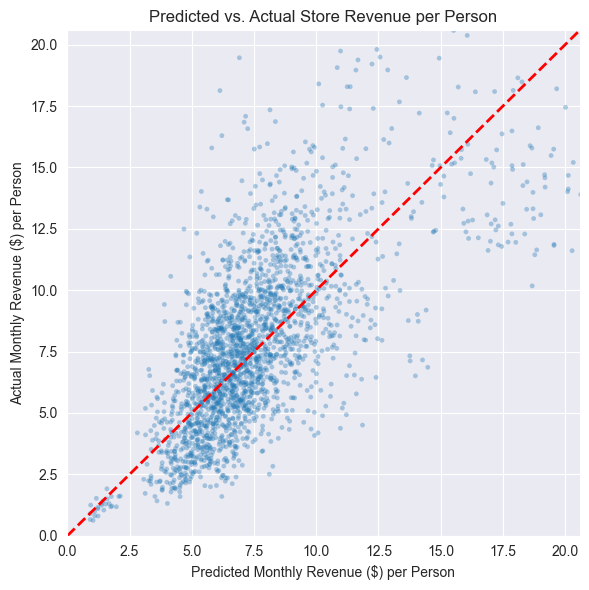

In [154]:
#predict after final fit
y_pred = predict_lr(X, B_final)
# 1) align CV preds to the df rows
df['predicted_log_revenue_per_person'] = y_pred

# 2) keep only rows with OOF predictions
mask = df['predicted_log_revenue_per_person'].notna()
df["revenue_per_person"] = df["revenue"] / df["population"]

# 3) back-transform predictions to dollars (BASE-10)
predicted_revenue = np.power(np.e, df.loc[mask, 'predicted_log_revenue'].to_numpy())
actual_revenue    = df.loc[mask, 'revenue_per_person'].to_numpy()  # already in dollars

# (optional) bias correction for log10 back-transform
resid = df.loc[mask, 'log_revenue_per_person'].to_numpy() - df.loc[mask, 'predicted_log_revenue_per_person'].to_numpy()
sigma2 = resid.var()  # variance on log10 scale
predicted_revenue_bc = predicted_revenue * np.exp((np.log(10.0)**2) * sigma2 / 2.0)

plt.figure(figsize=(6,6))
plt.scatter(predicted_revenue, actual_revenue, alpha=0.35, s=12, edgecolor='none')
plt.plot([0, actual_revenue.max()/3], [0, actual_revenue.max()/3], 'r--', lw=2)
plt.xlim(0, actual_revenue.max()/3)
plt.ylim(0, actual_revenue.max()/3)
plt.xlabel('Predicted Monthly Revenue ($) per Person')
plt.ylabel('Actual Monthly Revenue ($) per Person')
plt.title('Predicted vs. Actual Store Revenue per Person')
plt.tight_layout()
plt.show()

In [143]:
#betas of each feature
coef_names = ['intercept'] + list(X.columns)
nonstd_df = pd.DataFrame({
    'feature': coef_names,
    'beta': B_final
})
nonstd_df = nonstd_df[nonstd_df['feature'] != 'intercept']
nonstd_df = nonstd_df.reindex(
    nonstd_df['beta'].abs().sort_values(ascending=False).index
)
print(nonstd_df)

                       feature        beta
21                 store_ratio  648.596127
7                     pct_male  -10.590020
1                    vodka_ptc   -2.895521
3                  tequila_ptc    2.723873
2                  whiskey_ptc   -2.363400
5                   propOver21    0.695135
4                      rum_ptc   -0.216840
19                     month_5    0.132981
20                     month_6    0.074394
15                   pct_black    0.072737
16                     pct_api    0.071177
14            pct_foreign_born   -0.050309
18      pct_language_isolation    0.049216
17                    pct_aian   -0.044880
11       pct_high_school_lower   -0.033748
9               pct_unemployed    0.026851
22                    month_11    0.025459
13                pct_hispanic    0.024535
6                   median_age    0.007822
10           pct_below_poverty    0.005483
12  pct_families_below_poverty   -0.001061
8       pct_at_bachelor_degree    0.000122


Check standardized coefficients because their magnitudes actually tell us importance:

In [145]:
#importance of each feature
X_std = X.apply(pd.to_numeric, errors='coerce').astype(float).std(axis=0, ddof=0).to_numpy()
Y_std = pd.to_numeric(Y, errors='coerce').astype(float).std(ddof=0)
beta_no_intercept = np.ravel(B_final[1:])  # shape (p,)
std_beta = beta_no_intercept * (X_std / Y_std)
importance = (pd.DataFrame({"feature": X.columns, "std_coef": std_beta})
              .sort_values("std_coef", key=np.abs, ascending=False)
              .reset_index(drop=True))

print(importance)


                       feature  std_coef
0        pct_high_school_lower -0.309979
1             pct_foreign_born -0.308234
2                  whiskey_ptc -0.291027
3                  store_ratio  0.261432
4                 pct_hispanic  0.249416
5                    vodka_ptc -0.239197
6                    pct_black  0.222066
7                      pct_api  0.182267
8                     pct_male -0.175546
9                  tequila_ptc  0.154723
10      pct_language_isolation  0.141478
11                     month_5  0.071164
12                    pct_aian -0.062804
13              pct_unemployed  0.057980
14                  median_age  0.048971
15                     month_6  0.039811
16           pct_below_poverty  0.034852
17                  propOver21  0.029282
18                     rum_ptc -0.016915
19                    month_11  0.013624
20  pct_families_below_poverty -0.005517
21      pct_at_bachelor_degree  0.001819


Check for collinearity between features:

In [146]:
# compute correlation matrix for numeric features
corr = X.corr().abs()

# show only the top correlated pairs
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
print("Most correlated feature pairs:\n")
print(high_corr.head(10))


Most correlated feature pairs:

pct_foreign_born       pct_language_isolation        0.823051
pct_hispanic           pct_foreign_born              0.821608
pct_below_poverty      pct_families_below_poverty    0.817360
pct_hispanic           pct_language_isolation        0.792529
pct_foreign_born       pct_api                       0.723608
pct_black              pct_api                       0.693088
median_age             pct_api                       0.614981
tequila_ptc            pct_black                     0.564935
pct_high_school_lower  pct_language_isolation        0.551970
pct_foreign_born       pct_black                     0.542230
dtype: float64
